In [13]:
import sinter
import pymatching
import numpy as np
from typing import *
import math
import csv
from Surface import surface_data 
from generate_circuit import generate_circuit

# Generate the data
def my_circuit(n, noise, noise2):
    data = surface_data(n, 2 * n, n, 0, display_svg=False)
    circuit = generate_circuit(data, noise, noise2, n)
    return circuit

base = 1000
pr = np.arange(0.01, 0.35, 0.02)
#print(pr)

# Iterate over different n values
n_values = [3, 5, 7,9]
results = []

for n in n_values:
    Q3ubit_code_tasks = [
        sinter.Task(
            circuit=my_circuit(n, noise=0.005, noise2=p),
            json_metadata={'p': p},
        )
        for p in pr
    ]

    # Sampling
    collected_baconshor_code_stats: List[sinter.TaskStats] = sinter.collect(
        num_workers=9,
        tasks=Q3ubit_code_tasks,
        decoders=['pymatching'],
        max_shots=base * 1000,
        max_errors=base,
        print_progress=True,
    )

    # Get data (physical error rate=p, logical error rate=l)
    for stats in collected_baconshor_code_stats:
        p = stats.json_metadata['p']
        l = stats.errors / stats.shots if stats.errors != 0 else 0
        results.append([n, p, l])

# Save results to a CSV file
with open('results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['n', 'physical_error_rate', 'logical_error_rate'])
    writer.writerows(results)


Starting 9 workers...
17 cases left:
    pymatching processes=6  ~core_mins_left=1       shots_left=956800   errors_left=954     {p=0.01}
    pymatching processes=3  ~core_mins_left=1       shots_left=989200   errors_left=973     {p=0.03}
    pymatching processes=0  ~core_mins_left=9       shots_left=999500   errors_left=999     {p=0.049999999999999996}
    pymatching processes=0  ~core_mins_left=89      shots_left=999900   errors_left=1000    {p=0.06999999999999999}
    pymatching processes=0  ~core_mins_left=3       shots_left=999900   errors_left=996     {p=0.08999999999999998}
    pymatching processes=0  ~core_mins_left=9       shots_left=999900   errors_left=999     {p=0.10999999999999997}
    pymatching processes=0  ~core_mins_left=5       shots_left=999900   errors_left=998     {p=0.12999999999999998}
    pymatching processes=0  ~core_mins_left=9       shots_left=999900   errors_left=999     {p=0.15}
    pymatching processes=0  ~core_mins_left=86      shots_left=999900   errors_

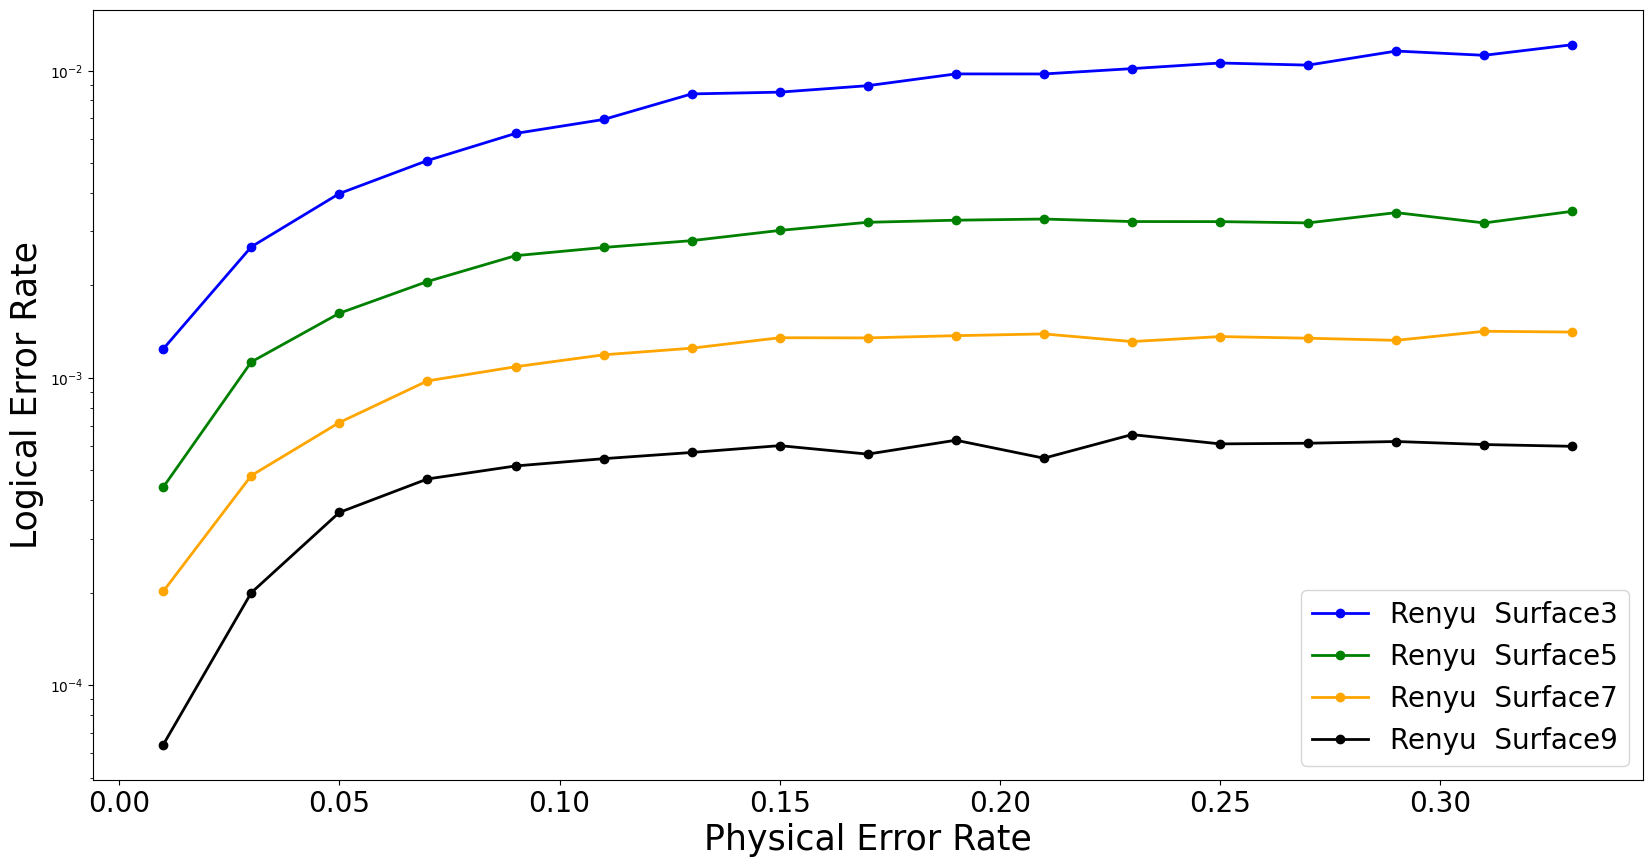

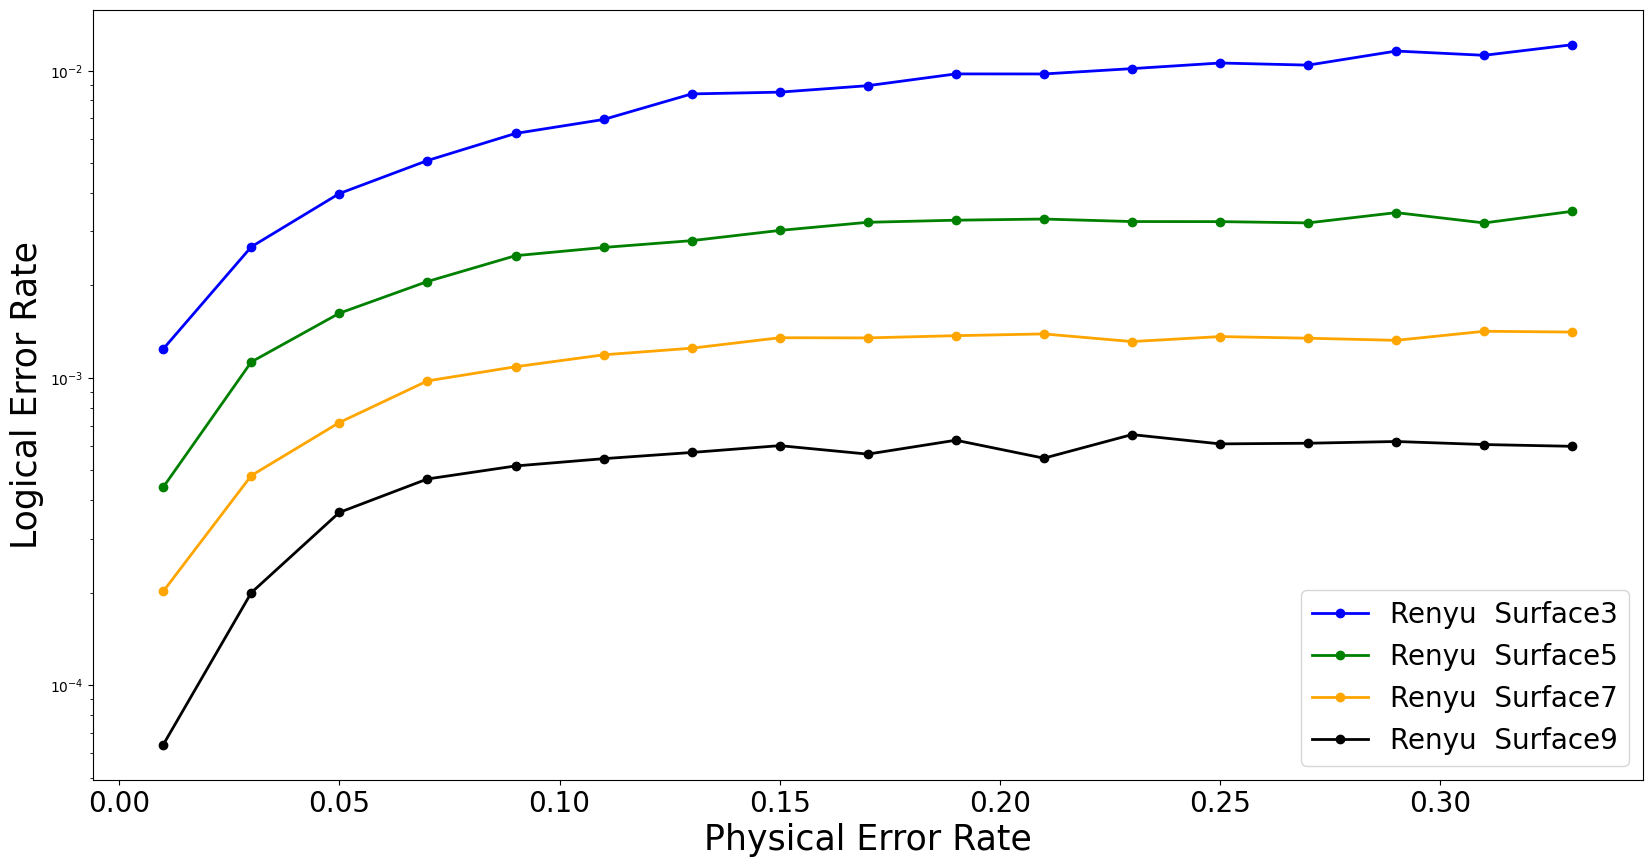

In [15]:
import matplotlib.pyplot as plt
import csv

def load_results_from_csv(filepath: str):
    results = []
    with open(filepath, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            n = int(row['n'])
            p = float(row['physical_error_rate'])
            l = float(row['logical_error_rate'])
            results.append([n, p, l])
    return results


import matplotlib.pyplot as plt
from collections import defaultdict

def plot_results(results):
    # Organize results into a dictionary
    data = defaultdict(lambda: {'plist': [], 'llist': []})
    
    for result in results:
        n, p, l = result
        data[n]['plist'].append(p)
        data[n]['llist'].append(l)

    plt.figure(figsize=(20, 10))

    # Generate colors dynamically if needed
    colors = ['blue', 'green', 'orange','black','purple']
    n_values = list(data.keys())

    if len(colors) < len(n_values):
        import itertools
        colors = list(itertools.cycle(colors))

    # Generate labels dynamically
    labels = [f'Renyu  Surface{n}' for n in n_values]

    for idx, n in enumerate(n_values):
        plist = data[n]['plist']
        llist = data[n]['llist']

        if len(plist) == 0 or len(llist) == 0:
            print(f'Warning: No data for n = {n}')
            continue

        # Combine plist and llist, sort by plist, and unzip
        sorted_data = sorted(zip(plist, llist))
        sorted_plist, sorted_llist = zip(*sorted_data)

        # Print data points to verify
        #print(f'n = {n}')
        #for p, l in zip(sorted_plist, sorted_llist):
            #print(f'Physical Error Rate: {p}, Logical Error Rate: {l}')

        # Plot data points and lines
        plt.plot(sorted_plist, sorted_llist, marker='o', linestyle='-', linewidth=2, color=colors[idx], label=labels[idx])

    # Add labels to plot
    #plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=20)
    #plt.yticks(fontsize=20)
    plt.xlabel("Physical Error Rate", fontsize=25)
    plt.ylabel("Logical Error Rate", fontsize=25)
    legend = plt.legend(title='', fontsize=20)
    plt.savefig('Renyu_Regular.pdf')
    plt.show()

plot_results(results)
# Or load from CSV and plot
data_from_csv = load_results_from_csv('results.csv')
plot_results(data_from_csv)
